In [1]:
#%matplotlib
import numpy as np
pi = np.pi
from qutip import *
from qutip.qip.circuit import QubitCircuit, Gate
from qutip.qip.operations import *
from qip.kpoprocessor import KPOProcessor
import scipy.io as spio

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
%load_ext autoreload
%autoreload 2

In [2]:
alpha = 2
num_lvl = 20
# computational basis
cat_plus = (coherent(num_lvl, alpha) + coherent(num_lvl, -alpha)).unit()
cat_minus = (coherent(num_lvl, alpha) - coherent(num_lvl, -alpha)).unit()
up = (cat_plus + cat_minus)/np.sqrt(2) # logical zero
down = (cat_plus - cat_minus)/np.sqrt(2) # logical one
# Identity
I = up*up.dag() + down*down.dag()
# sigma z
sigma_z = up*up.dag() - down*down.dag()
# sigma x
sigma_x = up*down.dag() + down*up.dag()
# sigma y
sigma_y = 1j*(-up*down.dag() + down*up.dag())

def rz(phi):
    return (-1j*phi/2*sigma_z).expm()

def rx(theta):
    return (-1j*theta/2*sigma_x).expm()

def ry(varphi):
    return (-1j*varphi/2*sigma_y).expm()

theta = 1.5*pi
if theta > pi:
    test_state = rz(pi)*rx(2*pi-theta)*up
else:
    test_state = rz(pi)*rx(theta)*up
target_state = rx(theta)*up
f = fidelity(test_state,target_state)
print(f)

1.0000000332243209


## $R_z(\phi)$ 

In [3]:
N = 1
phi = 2*pi
# Representation of a quantum program/algorithm, maintaining a sequence of gates.
qc = QubitCircuit(N = N)
qc.add_gate("RZ", 0, None, phi)
kpo = KPOProcessor(N = N)
tlist, coeffs = kpo.load_circuit(qc)
# set up parameters
alpha = kpo._paras['Coherent state']
num_lvl = kpo._paras['Cut off']
# computational basis
cat_plus = (coherent(num_lvl, alpha) + coherent(num_lvl, -alpha)).unit()
cat_minus = (coherent(num_lvl, alpha) - coherent(num_lvl, -alpha)).unit()
up = (cat_plus + cat_minus)/np.sqrt(2) # logical zero
down = (cat_plus - cat_minus)/np.sqrt(2) # logical one
# initial state
psi = (up+down).unit()
# target state
target_state = rz(phi)*psi
# simulate
kpo = KPOProcessor(N = N)
tlist, coeffs = kpo.load_circuit(qc)
result = kpo.run_state(init_state = psi, noisy = False)
final_state = result.states[-1]
f = fidelity(final_state,target_state)
print(f)

1.0000000178741304


## $R_x(\theta)$

In [4]:
N = 1
theta = 1.9*pi
# Representation of a quantum program/algorithm, maintaining a sequence of gates.
qc = QubitCircuit(N = N)
if theta > pi:
    qc.add_gate("RX", 0, None, 2*pi-theta)
    qc.add_gate("RZ", 0, None, pi)
kpo = KPOProcessor(N = N)
tlist, coeffs = kpo.load_circuit(qc)
# initial state
psi = up
# target state
target_state = rx(theta)*psi
# simulate
kpo = KPOProcessor(N = N)
tlist, coeffs = kpo.load_circuit(qc)
result = kpo.run_state(init_state = psi, noisy = False)
final_state = result.states[-1]
f = fidelity(final_state,target_state)
print(f)

0.9999948296218997


## $R_y(\varphi)$

In [6]:
N = 1
phi = 1.9*pi
# Representation of a quantum program/algorithm, maintaining a sequence of gates.
qc = QubitCircuit(N = N)
qc.add_gate("RY", 0, None, phi)
kpo = KPOProcessor(N = N)
tlist, coeffs = kpo.load_circuit(qc)
# set up parameters
alpha = kpo._paras['Coherent state']
num_lvl = kpo._paras['Cut off']
# computational basis
cat_plus = (coherent(num_lvl, alpha) + coherent(num_lvl, -alpha)).unit()
cat_minus = (coherent(num_lvl, alpha) - coherent(num_lvl, -alpha)).unit()
up = (cat_plus + cat_minus)/np.sqrt(2) # logical zero
down = (cat_plus - cat_minus)/np.sqrt(2) # logical one
# initial state
psi = (up+down).unit()
# target state
target_state = ry(phi)*psi
# simulate
result = kpo.run_state(init_state = psi, noisy = False)
final_state = result.states[-1]
f = fidelity(final_state,target_state)
print(f)

0.9999612441857488


## $U(\Theta)$

In [13]:
def carb(arg_value):
    # control arbitrary phase gate
    zz = tensor(sigmaz(),sigmaz())
    return (-1j*arg_value/2*zz).expm()

N = 2
arg_value = pi
qc = QubitCircuit(N = N)
qc.user_gates = {"CARB": carb}
qc.add_gate("CARB", targets = [0,1], arg_value = arg_value)
kpo = KPOProcessor(N = N)
tlist, coeffs = kpo.load_circuit(qc)
# set up parameters
alpha = kpo._paras['Coherent state']
num_lvl = kpo._paras['Cut off']
eye = qeye(num_lvl) # identity operator
# computational basis
cat_plus = (coherent(num_lvl, alpha) + coherent(num_lvl, -alpha)).unit()
cat_minus = (coherent(num_lvl, alpha) - coherent(num_lvl, -alpha)).unit()
up = (cat_plus + cat_minus)/np.sqrt(2) # logical zero
down = (cat_plus - cat_minus)/np.sqrt(2) # logical one

# sigma z
sigma_z = ket2dm(up) - ket2dm(down)
sigma_z1 = tensor([sigma_z,eye])
sigma_z2 = tensor([eye,sigma_z])

# ideal gate
def U(arg_value):
    return (-1j*arg_value/2*sigma_z1*sigma_z2).expm()

# initial state
psi = tensor([up+down,up+down]).unit()
# target state
target = U(arg_value)*psi
# simulate
result = kpo.run_state(init_state = psi, noisy = False)
final_state = result.states[-1]
f = fidelity(final_state,target)
print(f)

1.0000044032861022


## Wigner function

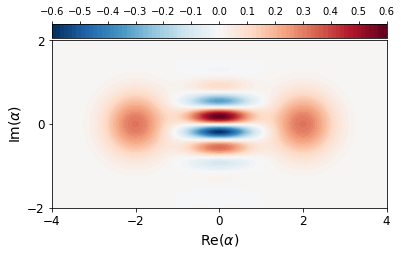

In [15]:
# Wigner function
xvec = np.linspace(-4,4,400)
yvec = np.linspace(-2,2,200)
W = wigner(final_state,xvec,yvec,'iterative',2)
nrm = mpl.colors.Normalize(-W.max(), W.max()) # Normalize colors

# Plot
fig, ax = plt.subplots()
cax = ax.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm)
cbar = fig.colorbar(cax, ax = ax, orientation='vertical')

# contour plot
plt.subplot(111,aspect='equal')
im = plt.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

# colorbar
cax = plt.axes([0.125, 0.8, 0.775, 0.05]) # left, bottom, width, height
plt.colorbar(im, cax = cax, orientation = 'horizontal', ticklocation = 'top', ticks = np.arange(round(W.min())-1,round(W.max()+.1)+.1,0.1));